In [ ]:
#!pip install pandas matplotlib seaborn scikit-learn numpy imblearn xgboost shap tabulate -q

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance
from tabulate import tabulate

In [3]:
# --- Arquivos de Entrada e Saída ---
INPUT_FILE = 'atendimentos_de_alunos_processado.csv'
OUTPUT_FILE = 'atendimentos_de_alunos_machine_learning.csv'

# --- Limpeza de Colunas ---
# Lista de colunas a serem removidas do dataset.
# Estas colunas são identificadores, datas ou informações redundantes que
# não agregam valor ao modelo de machine learning ou podem causar data leakage.
COLUMNS_TO_DROP = [
    'Grupo_percent_Cursado', 'Grupo_Acesso', 'MATRICULAID', '1º_NOME', 'DATAMATRICULA',
    'Data_de_nascimento', 'ENCERRAMENTO_CONTRATO',
    'DATAMATRICULA_is_missing', 'ENCERRAMENTO_CONTRATO_is_missing', 'PercentualConclusao',
    'Data_de_nascimento_is_missing', 'Situação_Contrato', 'idade'
]

# --- Exceções de Conversão ---
# Colunas que, apesar de conterem apenas 0 e 1, devem ser tratadas como
# numéricas (e escalonadas) em vez de booleanas.
BOOLEAN_CONVERSION_EXCEPTIONS = [
    'Correção_-_Plataforma', 'Ouvidoria', 'Processos_Secretaria', 'Suporte_Pedagogico'
]

In [4]:
df = pd.read_csv(INPUT_FILE, sep=';')

df.columns = (
    df.columns.str.strip()
    .str.replace(' ', '_', regex=False)
    .str.replace('%', 'percent', regex=False)
    .str.replace('#', 'num', regex=False)
)

df.head()

,Grupo_percent_Cursado,Grupo_Acesso,MATRICULAID,1º_NOME,DATAMATRICULA,ENCERRAMENTO_CONTRATO,NOME_CURSO_PADRÃO,Situação_Contrato,Documentos_Pessoais_Pendentes,Status_Cliente,...,Retenção,Solicitação_de_documentos,Suporte_de_Acesso,Suporte_Pedagogico,has_contact,DATAMATRICULA_is_missing,ENCERRAMENTO_CONTRATO_is_missing,Data_de_nascimento_is_missing,churn,Idade
0,01 - 0% Cursado,05 - Acima de 180 Dias,858262.0,Beatriz,06/12/2023,09/02/2025,TÉCNICO EM SEGURANÇA DO TRABALHO,0,"Fotos 3 X 4, Certidão de Nascimento ou Casamento",Quitado,...,0.0,0.0,0.0,0.0,1,0,0,1,1,32
1,02 - até 10% Cursado,05 - Acima de 180 Dias,859644.0,Gilva,06/12/2023,09/02/2025,TÉCNICO EM QUÍMICA,0,Não Informado,Quitado,...,0.0,0.0,0.0,0.0,1,0,0,1,1,32
2,01 - 0% Cursado,00 - Sem Acesso,859836.0,Herik,06/12/2023,09/02/2025,TÉCNICO EM RECURSOS HUMANOS,1,Não Informado,Quitado,...,0.0,0.0,0.0,0.0,1,0,0,0,0,26
3,01 - 0% Cursado,05 - Acima de 180 Dias,860124.0,NaN,09/03/2024,09/03/2025,TÉCNICO EM CONTABILIDADE,1,Não Informado,Não Informado,...,0.0,0.0,0.0,0.0,0,0,0,1,0,32
4,01 - 0% Cursado,01 - 30 Dias,863328.0,Juliana,06/12/2023,09/02/2025,TÉCNICO EM CONTABILIDADE,1,Não Informado,Quitado,...,0.0,0.0,0.0,0.0,1,0,0,1,0,32


In [5]:
# Garante que cada aluno (identificado por 'MATRICULAID') apareça apenas uma vez.
if 'MATRICULAID' in df.columns:
    df = df.drop_duplicates(subset='MATRICULAID', keep='first')

# Remove as colunas definidas na lista de configuração.
# 'errors="ignore"' previne falhas caso alguma coluna não seja encontrada.
df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')

print("Dimensões do DataFrame após remoção de duplicatas e colunas irrelevantes:")
print(df.shape)

Dimensões do DataFrame após remoção de duplicatas e colunas irrelevantes:
(14377, 39)


In [6]:
for column in ['percent_Docs_Pessoais']:
    if column in df.columns:
        df[column] = df[column].str.replace(',', '.', regex=False).astype(float)

print("Tipo de dado da coluna 'percent_Docs_Pessoais' após conversão:")
print(df['percent_Docs_Pessoais'].dtype)

Tipo de dado da coluna 'percent_Docs_Pessoais' após conversão:
float64


In [7]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
binary_columns = []
for column in numeric_columns:
    # Verifica se a column é binária (só contém 0 e 1) e não é uma exceção.
    is_binary = df[column].dropna().isin([0, 1]).all()
    if is_binary and column not in BOOLEAN_CONVERSION_EXCEPTIONS:
        binary_columns.append(column)

if binary_columns:
    df[binary_columns] = df[binary_columns].astype(bool)

print(f"columns convertidas para booleano: {binary_columns}")

columns convertidas para booleano: ['fezPrimeiroAcesso', 'has_contact', 'churn']


In [8]:
# As colunas numéricas que não foram convertidas para booleano serão escalonadas.
columns_to_standardize = [
    col for col in numeric_columns if col not in binary_columns
]

if columns_to_standardize:
    scaler = StandardScaler()
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    print(f"Colunas escalonadas com StandardScaler: {columns_to_standardize}")

# Visualizar o resultado do escalonamento
df[columns_to_standardize].describe()

Colunas escalonadas com StandardScaler: ['DisciplinasAprovadas', 'DisciplinasTotais', 'num_parcelas_Vencidas', 'percent_Docs_Pessoais', 'Total__Atendimentos', 'Acesso_ao_Portal', 'Anexar_Documentos', 'Apoio_Pedagogico', 'Bot_de_Atendimento', 'Contato_Via_Ligação', 'Correção_-_Plataforma', 'Correção_cadastral', 'Diploma', 'Disparos', 'Duvidas_Gerais', 'Erro', 'Estágio', 'Financeiro', 'Informações_Comercias', 'Onboarding', 'Outros_Atendimentos', 'Ouvidoria', 'Problema_Técnico', 'Processos_Secretaria', 'Reclame_aqui', 'Rematrícula', 'Retenção', 'Solicitação_de_documentos', 'Suporte_de_Acesso', 'Suporte_Pedagogico', 'Idade']


,DisciplinasAprovadas,DisciplinasTotais,num_parcelas_Vencidas,percent_Docs_Pessoais,Total__Atendimentos,Acesso_ao_Portal,Anexar_Documentos,Apoio_Pedagogico,Bot_de_Atendimento,Contato_Via_Ligação,...,Ouvidoria,Problema_Técnico,Processos_Secretaria,Reclame_aqui,Rematrícula,Retenção,Solicitação_de_documentos,Suporte_de_Acesso,Suporte_Pedagogico,Idade
count,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,14377.000000,1.437700e+04,1.437700e+04,1.437700e+04,...,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04,1.437700e+04
mean,2.372265e-17,-2.787411e-16,1.581510e-17,-2.372265e-17,7.907549e-18,-6.919106e-18,0.000000,7.907549e-18,-1.186132e-17,6.820261e-17,...,-8.401771e-18,9.884437e-19,-6.424884e-18,-3.212442e-17,-5.930662e-18,-6.919106e-18,-3.163020e-17,1.828621e-17,5.930662e-18,-5.930662e-17
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035,1.000035e+00,1.000035e+00,1.000035e+00,...,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,-8.070972e-01,-5.467263e+00,-7.211073e-01,-1.200691e+00,-1.119263e+00,-4.683960e-01,-0.330114,-2.634631e-01,-6.964997e-01,-9.136717e-02,...,-8.340286e-03,-1.368236e-01,-2.043300e-02,-7.052691e-02,-3.358677e-02,-7.963643e-02,-2.180718e-01,-7.489389e-02,-3.337856e-02,-4.806112e+00
25%,-8.070972e-01,-6.095738e-01,-7.211073e-01,-1.200691e+00,-7.382075e-01,-4.683960e-01,-0.330114,-2.634631e-01,-6.964997e-01,-9.136717e-02,...,-8.340286e-03,-1.368236e-01,-2.043300e-02,-7.052691e-02,-3.358677e-02,-7.963643e-02,-2.180718e-01,-7.489389e-02,-3.337856e-02,-7.382371e-02
50%,-5.208703e-01,-3.808097e-02,-7.211073e-01,1.553447e-01,-3.571518e-01,-4.683960e-01,-0.330114,-2.634631e-01,-2.318326e-01,-9.136717e-02,...,-8.340286e-03,-1.368236e-01,-2.043300e-02,-7.052691e-02,-3.358677e-02,-7.963643e-02,-2.180718e-01,-7.489389e-02,-3.337856e-02,-7.382371e-02
75%,7.671504e-01,2.476654e-01,5.579767e-01,1.059369e+00,5.478552e-01,-4.683960e-01,-0.330114,-2.634631e-01,6.975016e-01,-9.136717e-02,...,-8.340286e-03,-1.368236e-01,-2.043300e-02,-7.052691e-02,-3.358677e-02,-7.963643e-02,-2.180718e-01,-7.489389e-02,-3.337856e-02,-7.382371e-02
max,5.489893e+00,8.534311e+00,2.348694e+00,1.059369e+00,5.882634e+00,1.015117e+01,13.298155,1.811710e+01,9.526176e+00,1.894611e+01,...,1.199000e+02,1.616522e+01,4.894044e+01,2.917847e+01,5.361941e+01,2.328634e+01,1.864984e+01,3.004397e+01,2.995935e+01,6.137304e+00


In [9]:
# 'drop_first=True' remove a primeira categoria de cada feature para evitar multicolinearidade.
encoded_dataframe = pd.get_dummies(df, drop_first=True)

print("Dimensões do DataFrame após One-Hot Encoding:")
print(encoded_dataframe.shape)
encoded_dataframe.head()

Dimensões do DataFrame após One-Hot Encoding:
(14377, 149)


,DisciplinasAprovadas,DisciplinasTotais,num_parcelas_Vencidas,percent_Docs_Pessoais,fezPrimeiroAcesso,Total__Atendimentos,Acesso_ao_Portal,Anexar_Documentos,Apoio_Pedagogico,Bot_de_Atendimento,...,ESTADO_PU,ESTADO_RJ,ESTADO_RN,ESTADO_RO,ESTADO_RR,ESTADO_RS,ESTADO_SC,ESTADO_SE,ESTADO_SP,ESTADO_TO
0,-0.807097,-3.181291,-0.721107,0.155345,True,-0.833471,-0.468396,-0.330114,-0.263463,1.162169,...,False,False,False,False,False,False,False,False,False,False
1,-0.663984,-0.609574,-0.721107,1.059369,True,0.357327,-0.468396,-0.330114,-0.263463,-0.696500,...,False,False,False,False,False,False,False,False,False,False
2,-0.807097,0.247665,-0.721107,1.059369,False,-0.404784,-0.468396,-0.330114,-0.263463,1.162169,...,False,False,False,False,False,False,False,False,False,False
3,-0.807097,0.247665,-0.721107,-1.200691,True,-1.119263,-0.468396,-0.330114,-0.263463,-0.696500,...,False,False,False,False,False,False,False,False,False,False
4,-0.807097,0.247665,-0.721107,1.059369,True,1.262335,0.859049,3.076953,-0.263463,-0.231833,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# O get_dummies transforma colunas booleanas (como 'churn') em True/False.
# Convertemos de volta para 1/0.
if 'churn' in encoded_dataframe.columns:
    encoded_dataframe['churn'] = encoded_dataframe['churn'].astype(int)
    print("Valores únicos na coluna 'churn' após finalização:")
    print(encoded_dataframe['churn'].unique())

Valores únicos na coluna 'churn' após finalização:
[1 0]


In [11]:
encoded_dataframe.to_csv(OUTPUT_FILE, index=False, sep=';')

print(f"Processamento concluído com sucesso!")
print(f"Arquivo salvo em: {OUTPUT_FILE}")

Processamento concluído com sucesso!
Arquivo salvo em: atendimentos_de_alunos_machine_learning.csv


In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(OUTPUT_FILE, sep=';')

print("Dados carregados com sucesso.")

# 'X' conterá todas as colunas, exceto 'churn'.
# O 'axis=1' especifica que estamos removendo uma coluna.
X = df.drop('churn', axis=1)

# 'y' conterá apenas a coluna 'churn'.
y = df['churn']

print("Features (X) e Alvo (y) foram definidos.")
print("Dimensões de X:", X.shape)
print("Dimensões de y:", y.shape)

# --- Primeira Divisão: Separando o conjunto de Teste (20% do total) ---
# O conjunto de teste é a nossa "prova final" e deve ser guardado até o fim.
# Usamos 'stratify=y' para garantir que a proporção de churn/não-churn seja a mesma
# no conjunto original e no conjunto de teste, o que é vital para dados desbalanceados.
# 'random_state=42' garante que a divisão seja sempre a mesma, tornando o resultado reprodutível.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% dos dados para o conjunto de teste
    random_state=42,
    stratify=y
)

# --- Segunda Divisão: Separando Treino e Validação a partir do restante (80%) ---
# Agora, dividimos os 80% restantes em treino e validação.
# O 'test_size=0.2' aqui significa 20% *dos 80% restantes*, resultando em:
# - 80% de X_temp para treino (64% do total)
# - 20% de X_temp para validação (16% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,      # 20% do conjunto temporário para validação
    random_state=42,
    stratify=y_temp     # Estratifica novamente para manter a proporção
)

print("Dados divididos em conjuntos de treino, validação e teste.")

Dados carregados com sucesso.
Features (X) e Alvo (y) foram definidos.
Dimensões de X: (14377, 148)
Dimensões de y: (14377,)
Dados divididos em conjuntos de treino, validação e teste.


Treinando o modelo de Regressão Logística...
Modelo treinado com sucesso.

--- 10 Amostras Aleatórias do Conjunto de Teste ---
|   Real |   Previsto |   Prob_Nao_Churn (0) |   Prob_Churn (1) |
|-------:|-----------:|---------------------:|-----------------:|
|      0 |          0 |            0.823069  |        0.176931  |
|      1 |          1 |            0.0934587 |        0.906541  |
|      1 |          1 |            0.0237629 |        0.976237  |
|      0 |          0 |            0.808088  |        0.191912  |
|      0 |          0 |            0.679793  |        0.320207  |
|      0 |          1 |            0.468697  |        0.531303  |
|      0 |          0 |            0.904881  |        0.0951191 |
|      1 |          1 |            0.0475322 |        0.952468  |
|      0 |          0 |            0.742949  |        0.257051  |
|      0 |          0 |            0.882198  |        0.117802  |

Gerando a visualização gráfica...


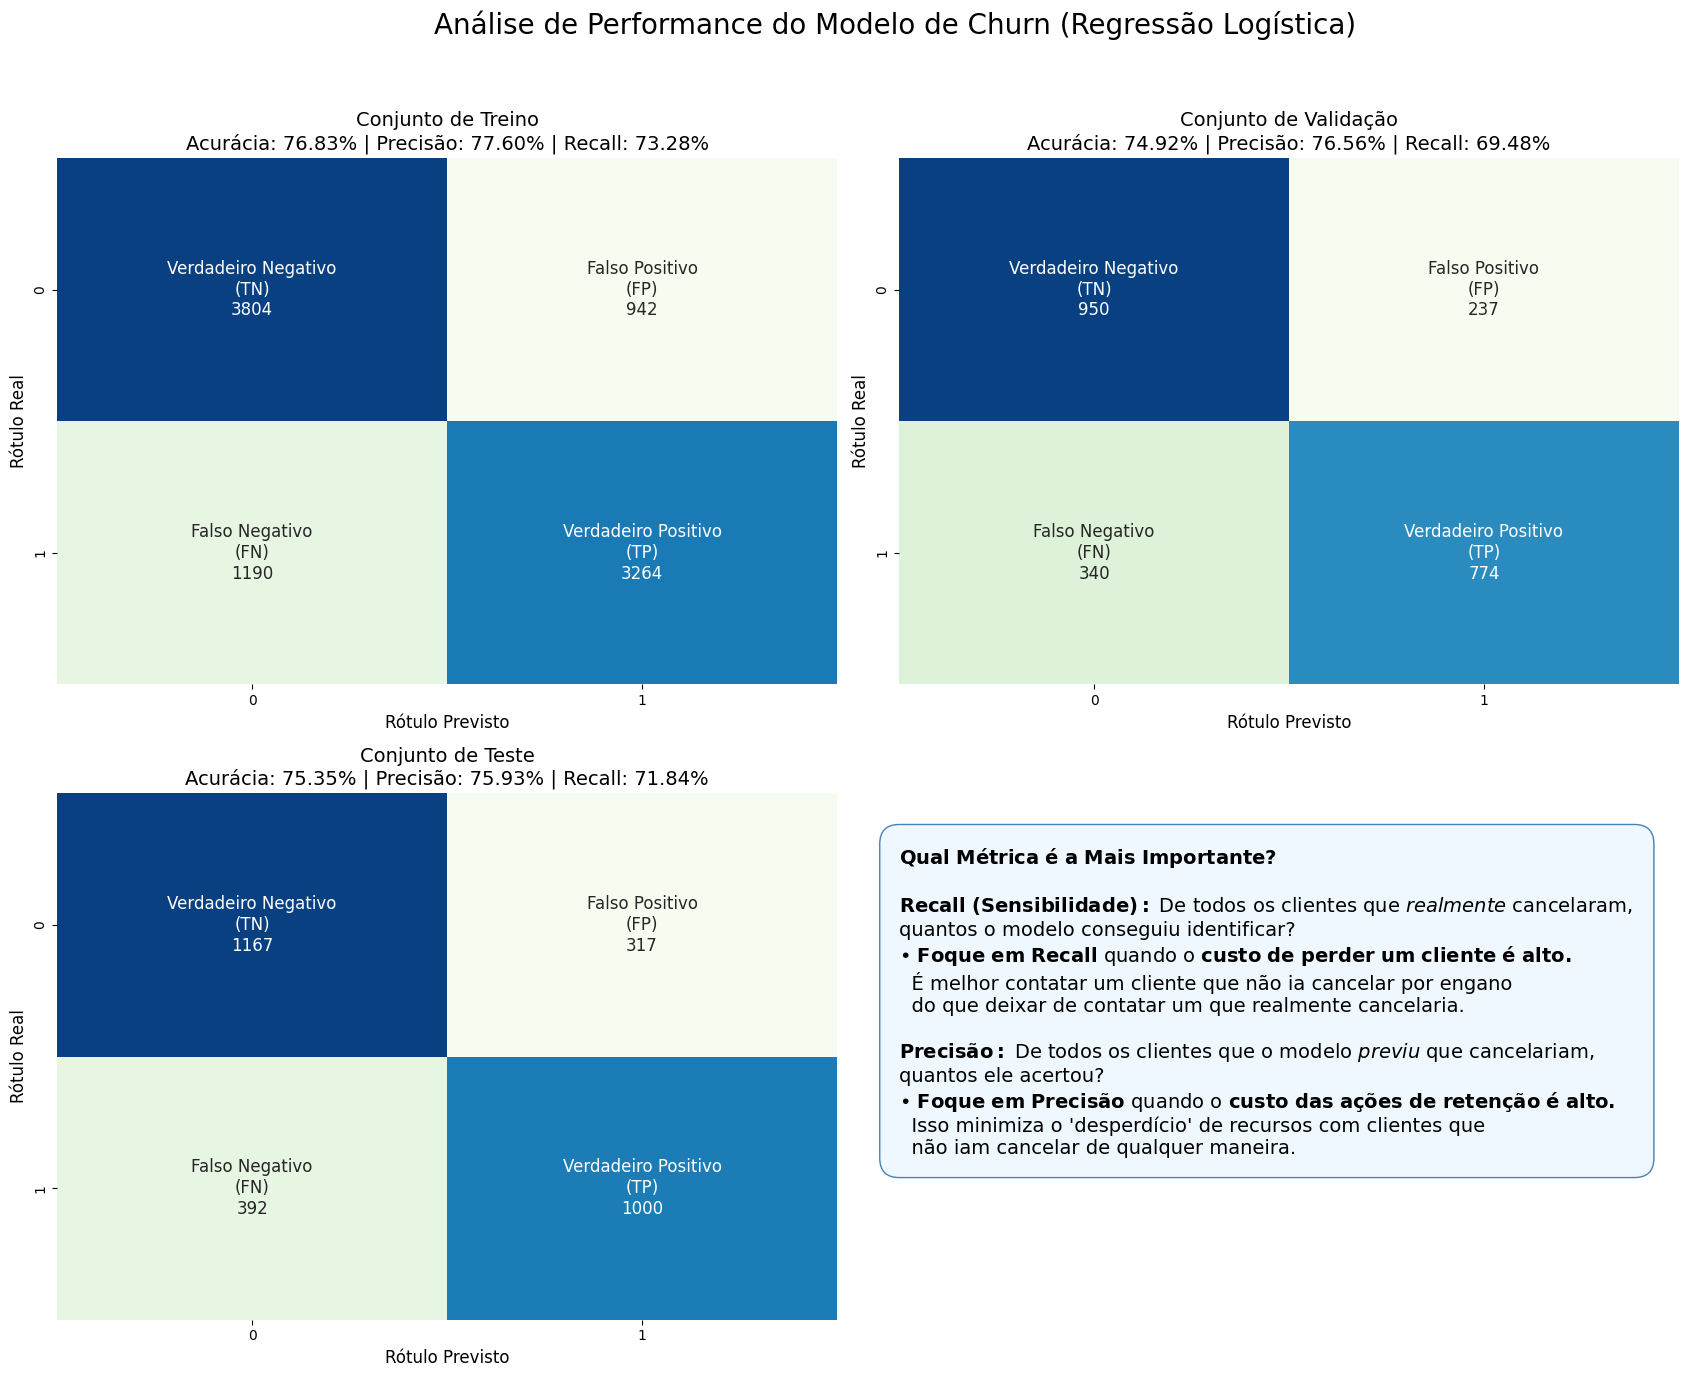


Visualização gerada com sucesso.


In [ ]:
# --- Treinamento do Modelo ---
print("Treinando o modelo de Regressão Logística...")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
print("Modelo treinado com sucesso.")

# --- Previsões de Classe e Probabilidade ---

y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)
y_test_pred = log_reg.predict(X_test)

# Gera as probabilidades de churn (classe 1) para o conjunto de teste.
y_test_prob = log_reg.predict_proba(X_test)

# --- Tabela de Probabilidades (Amostra Aleatória) ---

model_predictions_df = pd.DataFrame({
    'Real': y_test.values,
    'Previsto': y_test_pred,
    'Prob_Nao_Churn (0)': y_test_prob[:, 0],
    'Prob_Churn (1)': y_test_prob[:, 1]
}, index=y_test.index)

# Seleciona e exibe 10 amostras aleatórias do DataFrame de previsões.
print("\n--- 10 Amostras Aleatórias do Conjunto de Teste ---")
random_10_samples_df = model_predictions_df.sample(10, random_state=42)
print(random_10_samples_df.to_markdown(index=False))


# --- Função de Plotagem para a Matriz de Confusão ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """Plota uma única matriz de confusão anotada."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Cálculo das métricas
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Rótulos para anotação
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])

    sns.heatmap(cm, annot=labels, fmt='', cmap='GnBu', cbar=False, ax=ax, annot_kws={"size": 12})
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criação da Imagem Consolidada ---
print("\nGerando a visualização gráfica...")
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise de Performance do Modelo de Churn (Regressão Logística)', fontsize=20, y=0.98)
axes = axes.ravel()

# Plotar cada matriz
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treino')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# Adicionar o texto explicativo
ax_text = axes[3]
ax_text.axis('off')
text_content = (
    r"$\bf{Qual\ Métrica\ é\ a\ Mais\ Importante?}$" "\n\n"
    r"$\bf{Recall\ (Sensibilidade):}$" " De todos os clientes que " r"$\it{realmente}$" " cancelaram, \n"
    "quantos o modelo conseguiu identificar? \n"
    "• " r"$\bf{Foque\ em\ Recall}$" " quando o " r"$\bf{custo\ de\ perder\ um\ cliente\ é\ alto.}$" "\n"
    "  É melhor contatar um cliente que não ia cancelar por engano\n"
    "  do que deixar de contatar um que realmente cancelaria."
    "\n\n"
    r"$\bf{Precisão:}$" " De todos os clientes que o modelo " r"$\it{previu}$" " que cancelariam, \n"
    "quantos ele acertou? \n"
    "• " r"$\bf{Foque\ em\ Precisão}$" " quando o " r"$\bf{custo\ das\ ações\ de\ retenção\ é\ alto.}$" "\n"
    "  Isso minimiza o 'desperdício' de recursos com clientes que \n"
    "  não iam cancelar de qualquer maneira."
)
ax_text.text(
    0.0, 0.9, text_content, ha='left', va='top', fontsize=14, wrap=True,
    bbox=dict(boxstyle='round,pad=1', fc='aliceblue', ec='steelblue')
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print("\nVisualização gerada com sucesso.")

Modelo treinado com sucesso.

--- 10 Amostras Aleatórias de Previsões (Random Forest) ---
|   Real |   Previsto |   Prob_Nao_Churn (0) |   Prob_Churn (1) |
|-------:|-----------:|---------------------:|-----------------:|
|      0 |          0 |            0.868199  |         0.131801 |
|      1 |          1 |            0.190573  |         0.809427 |
|      1 |          1 |            0.0840642 |         0.915936 |
|      0 |          0 |            0.875885  |         0.124115 |
|      0 |          0 |            0.778498  |         0.221502 |
|      0 |          1 |            0.447065  |         0.552935 |
|      0 |          0 |            0.763791  |         0.236209 |
|      1 |          1 |            0.116619  |         0.883381 |
|      0 |          0 |            0.813666  |         0.186334 |
|      0 |          0 |            0.782778  |         0.217222 |

Gerando a visualização gráfica...


/tmp/ipykernel_11114/1517507129.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


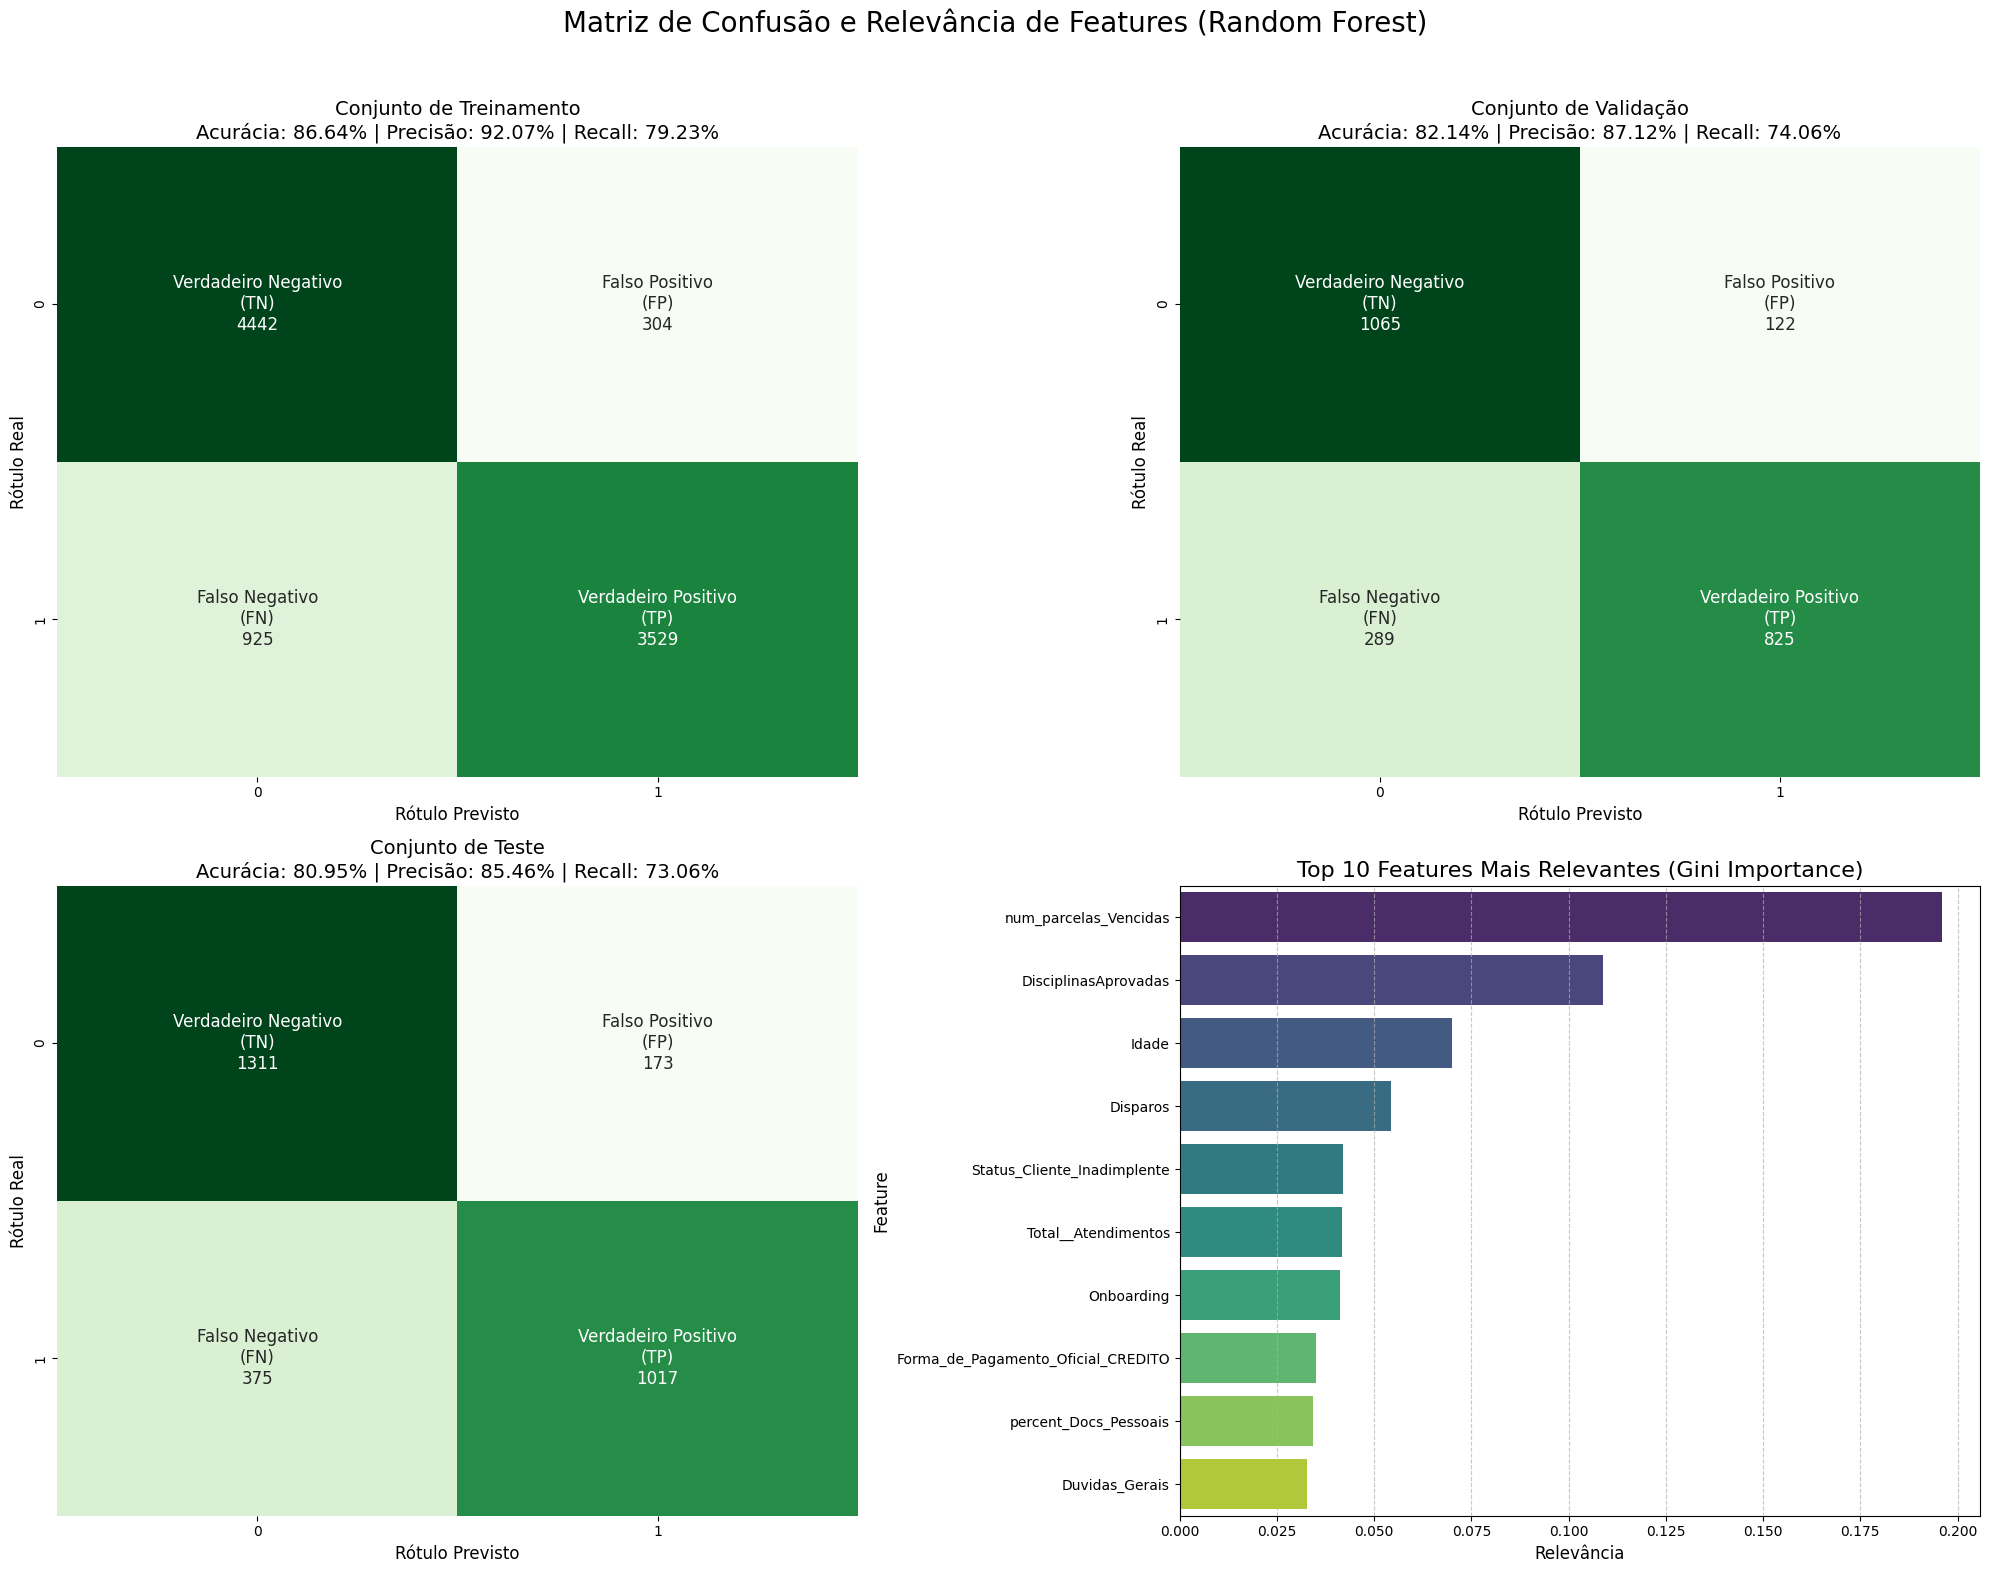


Visualização gerada com sucesso.


In [ ]:
# --- Treinamento do Modelo (Random Forest) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train, y_train)
print("Modelo treinado com sucesso.")

# --- Previsões e Probabilidades ---
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Gera as probabilidades para o conjunto de teste
y_test_prob = rf_model.predict_proba(X_test)


# --- Tabela de Probabilidades (Amostra Aleatória) ---
rf_predictions_df = pd.DataFrame({
    'Real': y_test.values,
    'Previsto': y_test_pred,
    'Prob_Nao_Churn (0)': y_test_prob[:, 0],
    'Prob_Churn (1)': y_test_prob[:, 1]
}, index=y_test.index)

# Seleciona e exibe 10 amostras aleatórias do DataFrame de previsões.
print("\n--- 10 Amostras Aleatórias de Previsões (Random Forest) ---")
random_10_rf_samples_df = rf_predictions_df.sample(10, random_state=42)
print(random_10_rf_samples_df.to_markdown(index=False))


# --- Função de Plotagem para uma Única Matriz ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.\nVerifique os rótulos y_true e y_pred.', 
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens', cbar=False, ax=ax, annot_kws={"size": 12})
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---
print("\nGerando a visualização gráfica...")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Matriz de Confusão e Relevância de Features (Random Forest)', fontsize=20, y=0.98)
axes = axes.ravel()

# Plotar cada matriz de confusão
# Assume-se que y_train, y_val, e y_test já existem.
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features (Feature Importance) ---
ax_importance = axes[3]
importances = rf_model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Criar o gráfico de barras com as 10 features mais importantes
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(10), # Seleciona apenas as 10 primeiras linhas
    ax=ax_importance, 
    palette='viridis'
)

# Ajustar o título para refletir a mudança
ax_importance.set_title('Top 10 Features Mais Relevantes (Gini Importance)', fontsize=16)
ax_importance.set_xlabel('Relevância', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("\nVisualização gerada com sucesso.")

--- 10 Amostras Aleatórias de Previsões (Decision Tree) ---
|   Real |   Previsto |   Prob_Nao_Churn (0) |   Prob_Churn (1) |
|-------:|-----------:|---------------------:|-----------------:|
|      0 |          0 |            0.955752  |        0.0442478 |
|      1 |          1 |            0.0411985 |        0.958801  |
|      1 |          1 |            0         |        1         |
|      0 |          0 |            0.955752  |        0.0442478 |
|      0 |          0 |            0.942434  |        0.0575658 |
|      0 |          0 |            0.760563  |        0.239437  |
|      0 |          0 |            0.942434  |        0.0575658 |
|      1 |          1 |            0         |        1         |
|      0 |          0 |            0.942434  |        0.0575658 |
|      0 |          0 |            0.766484  |        0.233516  |

Gerando a visualização da matriz de confusão e relevância de features...


/tmp/ipykernel_11114/1563222440.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), ax=ax_importance, palette='Reds')


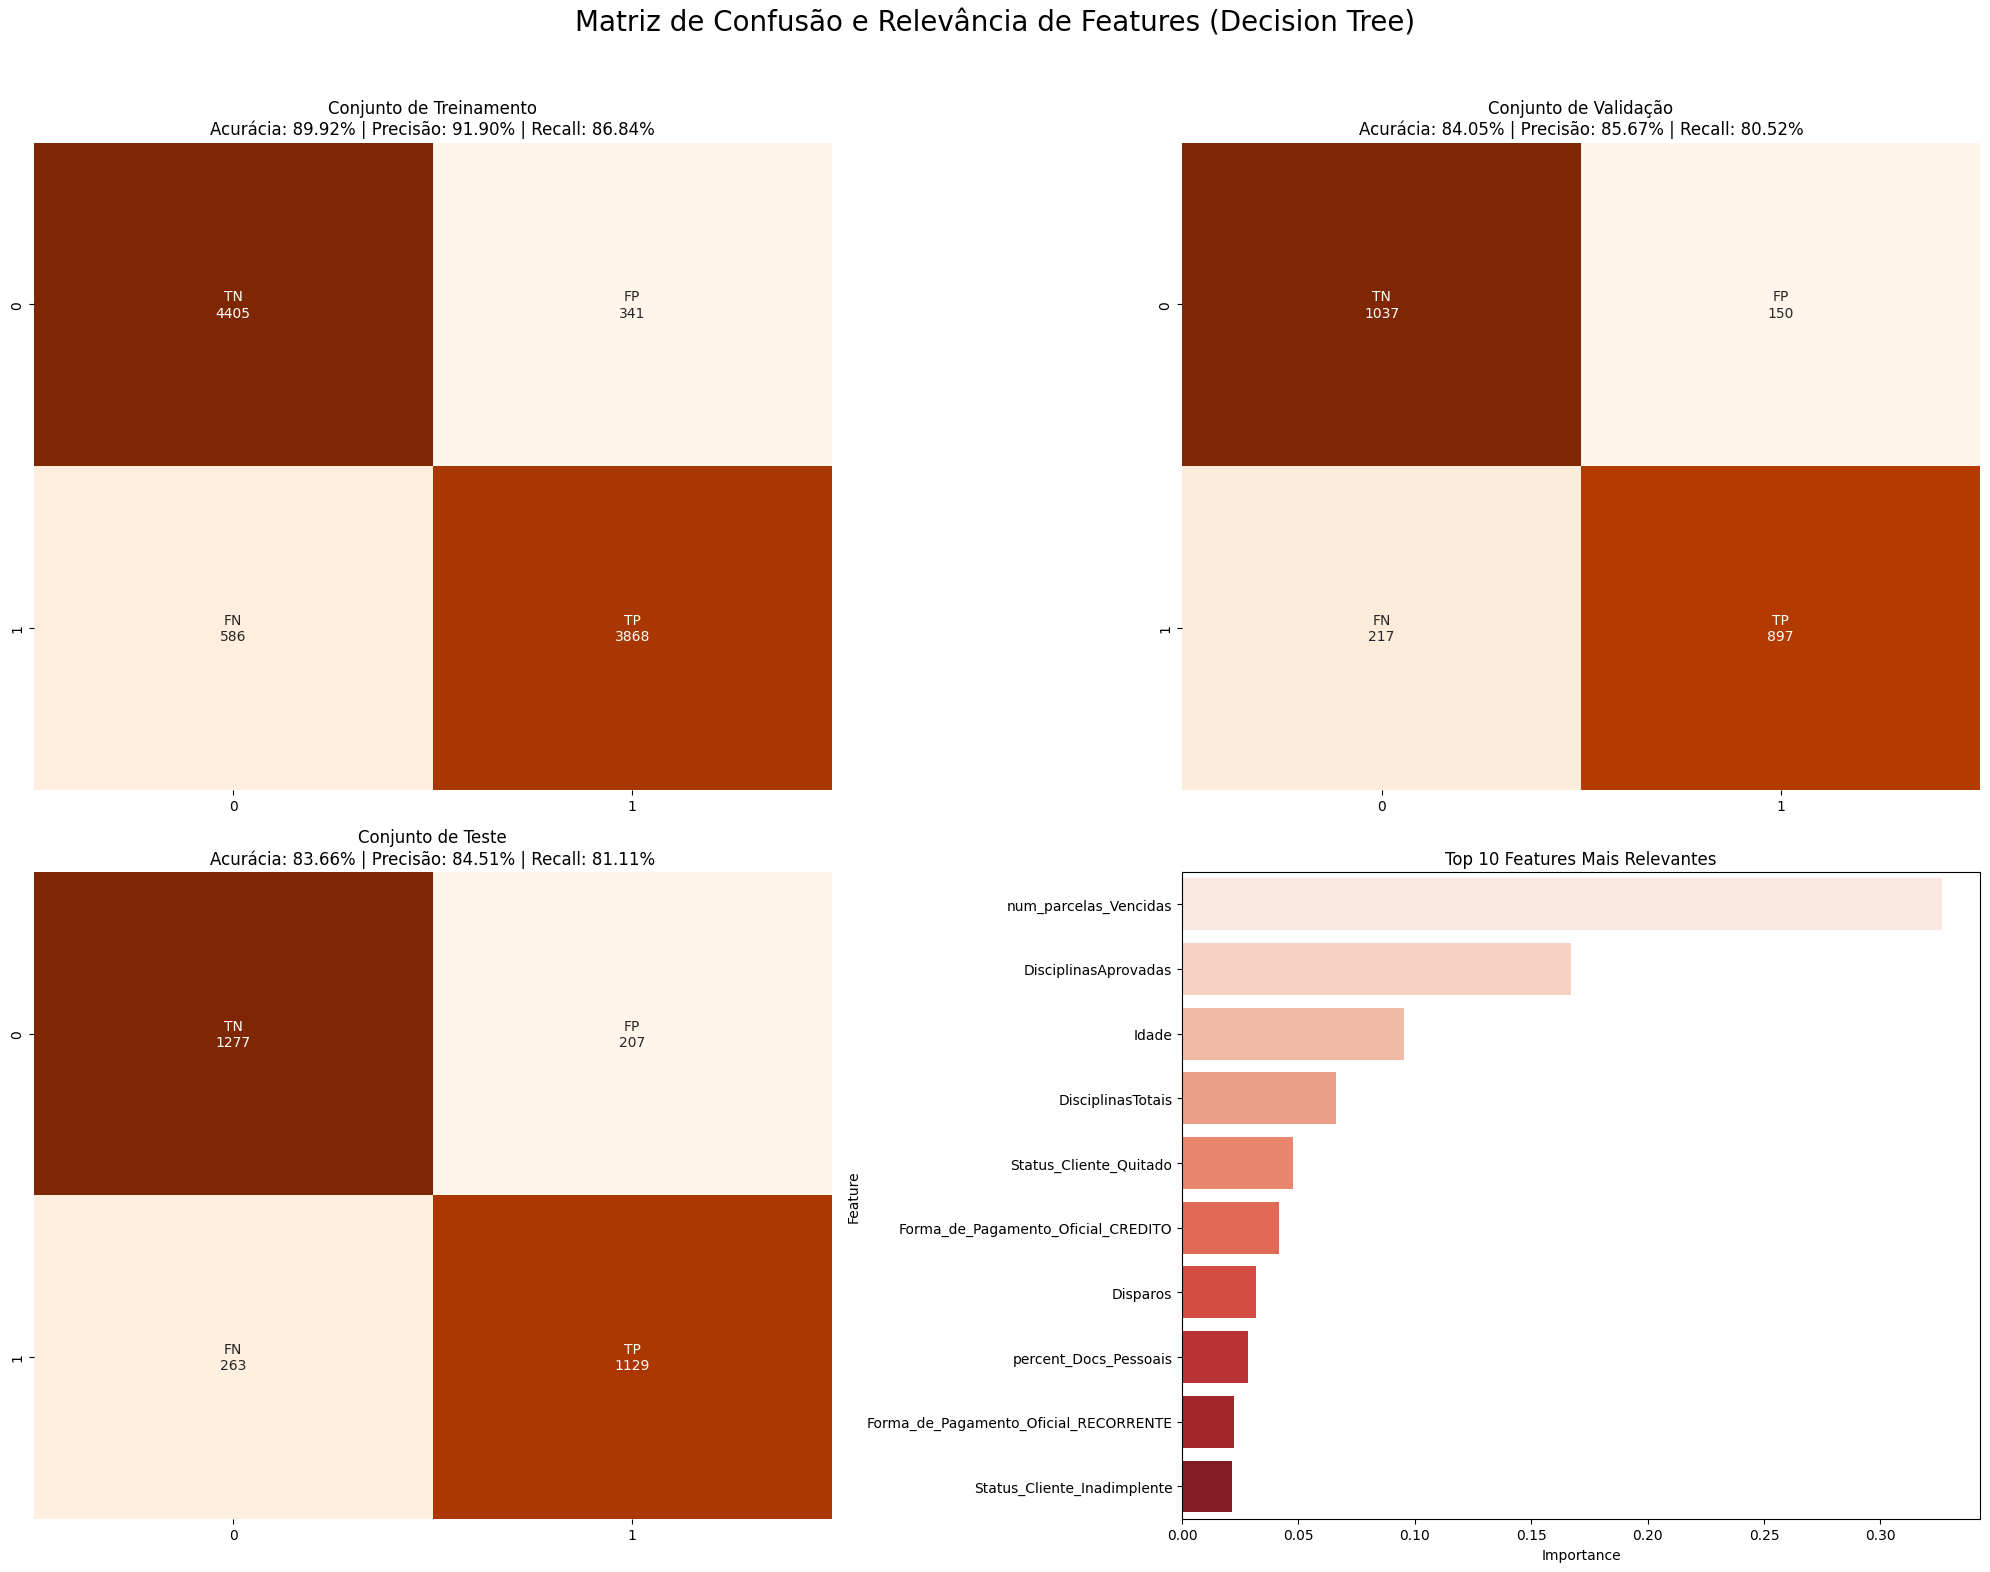

In [23]:
# --- Treinamento do Modelo (Decision Tree) ---
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# --- Previsões e Probabilidades ---
y_train_pred = dt_model.predict(X_train)
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)
y_test_prob = dt_model.predict_proba(X_test)


# --- Tabela de Probabilidades (Amostra Aleatória) ---
dt_predictions_df = pd.DataFrame({
    'Real': y_test.values,
    'Previsto': y_test_pred,
    'Prob_Nao_Churn (0)': y_test_prob[:, 0],
    'Prob_Churn (1)': y_test_prob[:, 1]
}, index=getattr(y_test, 'index', range(len(y_test))))

print("--- 10 Amostras Aleatórias de Previsões (Decision Tree) ---")
random_10_dt_samples_df = dt_predictions_df.sample(10, random_state=42)
print(random_10_dt_samples_df.to_markdown(index=False))

# --- Criar a Imagem Consolidada (Matrizes de Confusão e Feature Importance) ---
print("\nGerando a visualização da matriz de confusão e relevância de features...")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Matriz de Confusão e Relevância de Features (Decision Tree)', fontsize=20, y=0.98)
axes = axes.ravel()

# --- Função de Plotagem para uma Única Matriz ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.', ha='center', va='center')
        ax.set_title(title)
        return
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    labels = np.array([[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']])
    sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', cbar=False, ax=ax)
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}')

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features ---
ax_importance = axes[3]
importances = dt_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), ax=ax_importance, palette='Reds')
ax_importance.set_title('Top 10 Features Mais Relevantes')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Iniciando o treinamento do modelo SVC...
Treinamento concluído.

--- 10 Amostras Aleatórias de Previsões (SVC) ---
|   Real |   Previsto |   Prob_Nao_Churn (0) |   Prob_Churn (1) |
|-------:|-----------:|---------------------:|-----------------:|
|      0 |          0 |            0.793298  |        0.206702  |
|      1 |          1 |            0.0849118 |        0.915088  |
|      1 |          1 |            0.0285504 |        0.97145   |
|      0 |          0 |            0.807738  |        0.192262  |
|      0 |          0 |            0.658407  |        0.341593  |
|      0 |          0 |            0.524201  |        0.475799  |
|      0 |          0 |            0.883452  |        0.116548  |
|      1 |          1 |            0.0738298 |        0.92617   |
|      0 |          0 |            0.709889  |        0.290111  |
|      0 |          0 |            0.900004  |        0.0999956 |

Gerando a visualização gráfica...


/tmp/ipykernel_11114/256494481.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


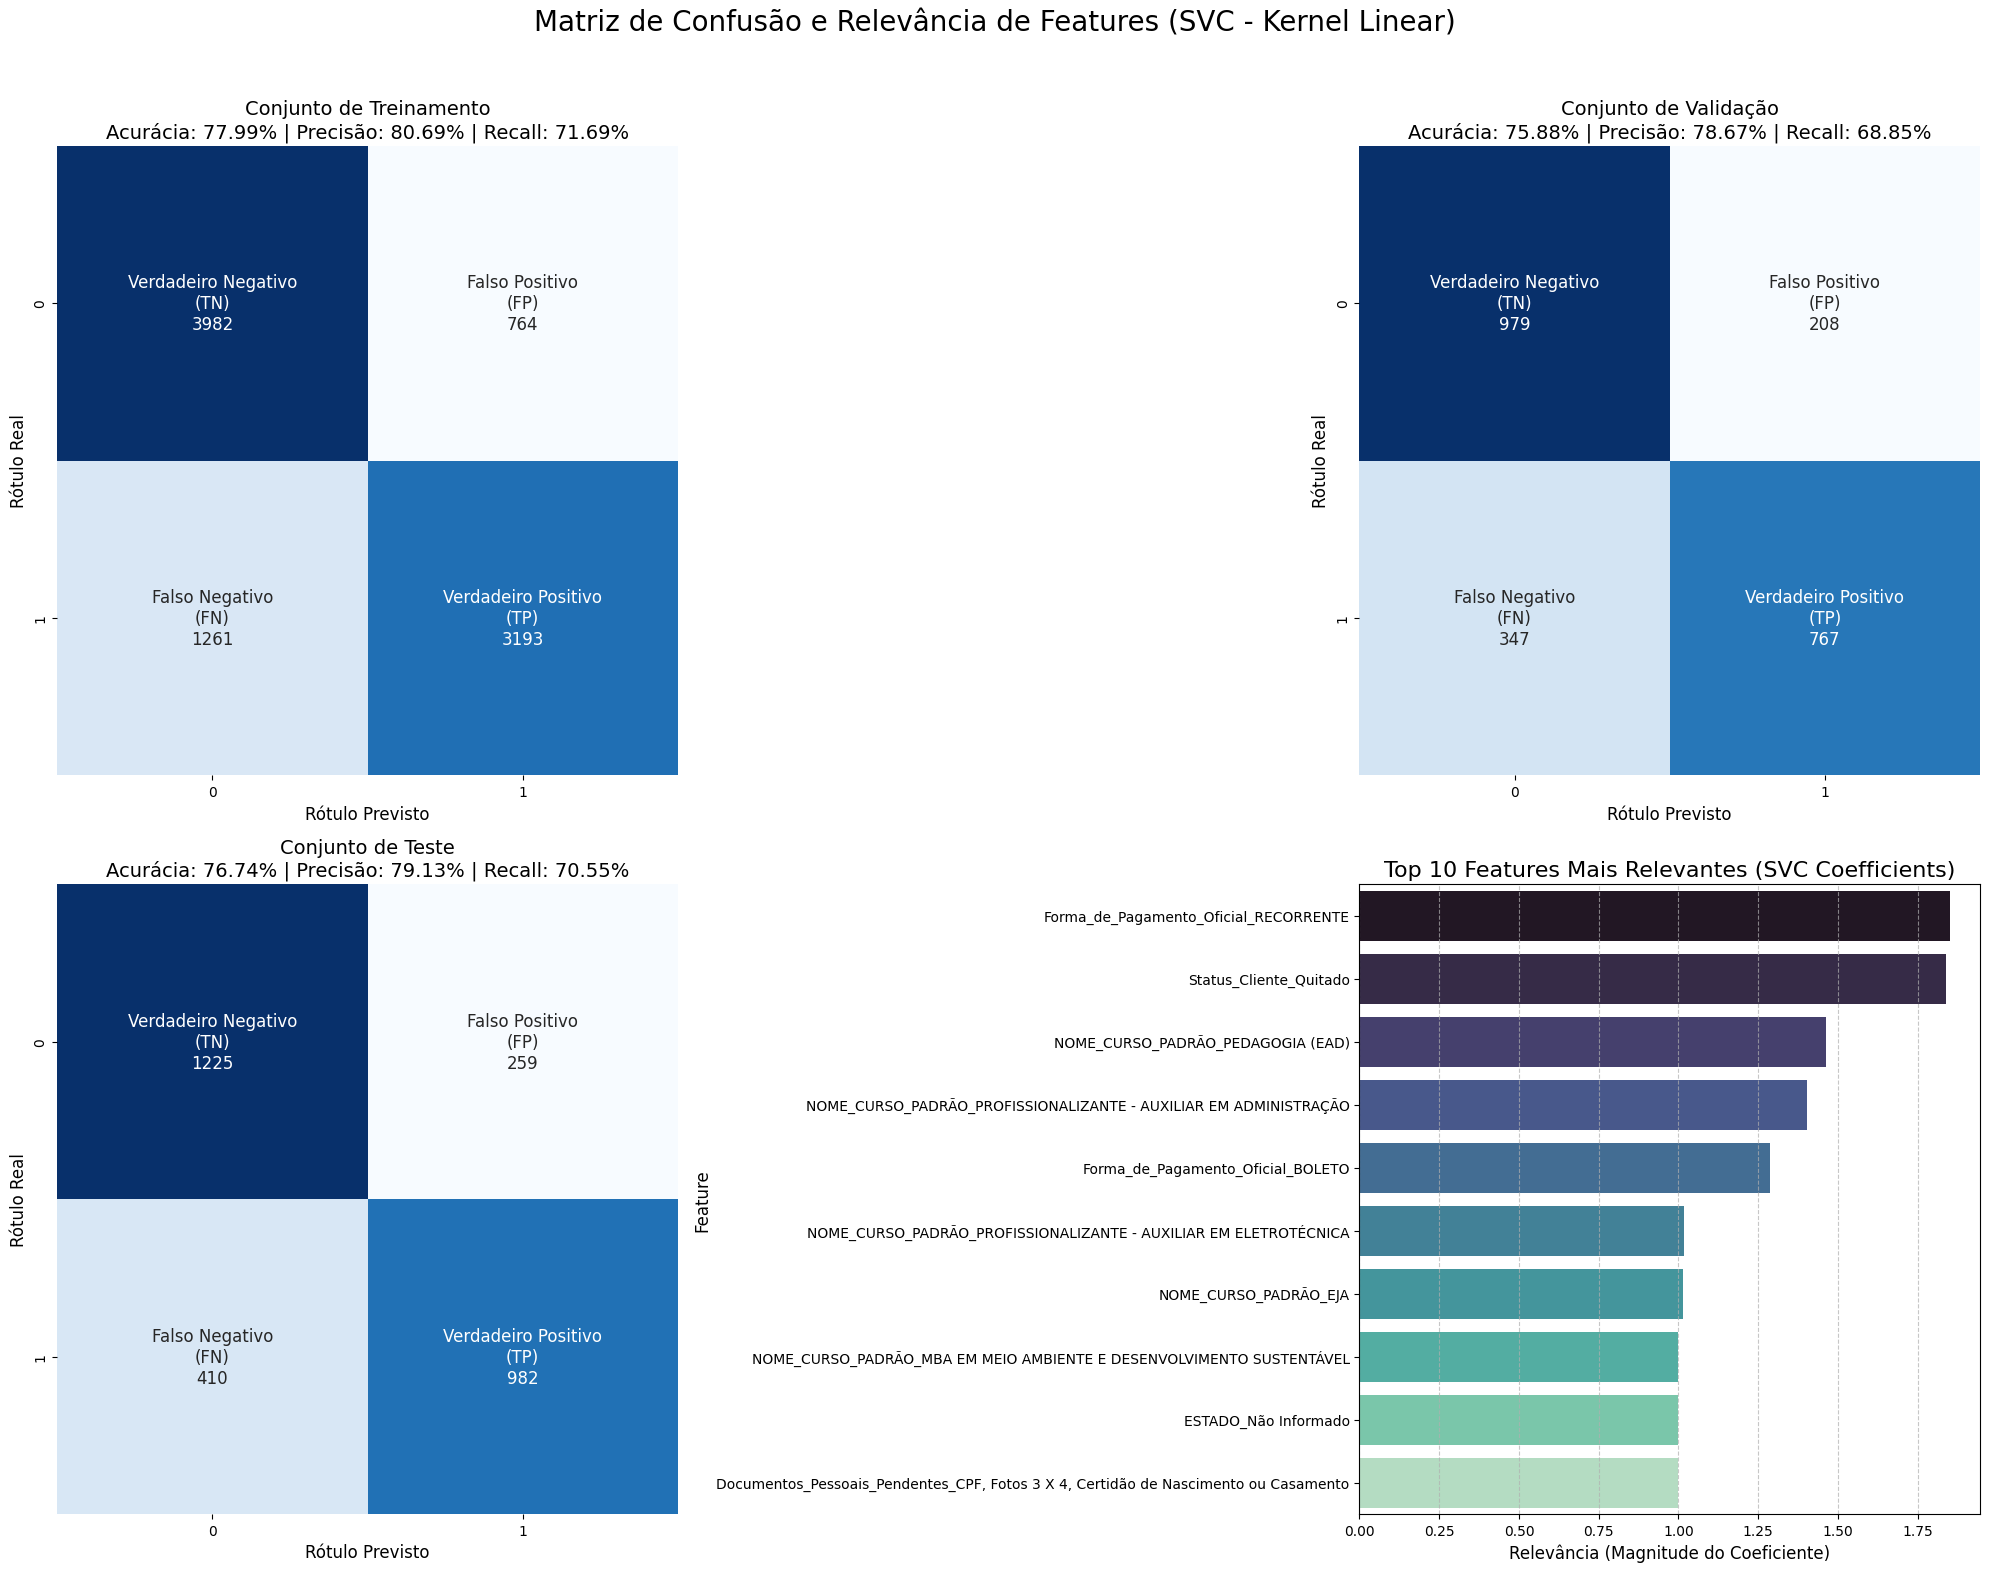

In [ ]:
# --- Treinamento do Modelo (Usando SVC com Kernel Linear e Probabilidade) ---
print("Iniciando o treinamento do modelo SVC...")
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
print("Treinamento concluído.")

# --- Previsões e Probabilidades ---
y_train_pred = svm_model.predict(X_train)
y_val_pred = svm_model.predict(X_val)
y_test_pred = svm_model.predict(X_test)
y_test_prob = svm_model.predict_proba(X_test)


# --- Tabela de Probabilidades (Amostra Aleatória) ---
# Cria um DataFrame com os resultados do conjunto de teste.
svm_predictions_df = pd.DataFrame({
    'Real': y_test.values,
    'Previsto': y_test_pred,
    'Prob_Nao_Churn (0)': y_test_prob[:, 0],
    'Prob_Churn (1)': y_test_prob[:, 1]
}, index=getattr(y_test, 'index', range(len(y_test))))

# Seleciona e exibe 10 amostras aleatórias do DataFrame de previsões.
print("\n--- 10 Amostras Aleatórias de Previsões (SVC) ---")
random_10_svm_samples_df = svm_predictions_df.sample(10, random_state=42)
print(random_10_svm_samples_df.to_markdown(index=False))


# --- Função de Plotagem para uma Única Matriz (Sem alterações) ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.\nVerifique os rótulos y_true e y_pred.',
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax, annot_kws={"size": 12})
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---
print("\nGerando a visualização gráfica...")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Matriz de Confusão e Relevância de Features (SVC - Kernel Linear)', fontsize=20, y=0.98)
axes = axes.ravel()

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features ---
ax_importance = axes[3]
importances = np.abs(svm_model.coef_[0])

# Garante que temos os nomes das features
if isinstance(X, pd.DataFrame):
    feature_names = X.columns
else:
    feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(10),
    ax=ax_importance,
    palette='mako'
)

ax_importance.set_title('Top 10 Features Mais Relevantes (SVC Coefficients)', fontsize=16)
ax_importance.set_xlabel('Relevância (Magnitude do Coeficiente)', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Iniciando o treinamento do modelo XGBoost...


/home/bard/Projects/PAD/FMF_Churn-PAD/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:02:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Treinamento concluído.

--- 10 Amostras Aleatórias de Previsões (XGBoost) ---
|   Real |   Previsto |   Prob_Nao_Churn (0) |   Prob_Churn (1) |
|-------:|-----------:|---------------------:|-----------------:|
|      0 |          0 |          0.969288    |       0.0307123  |
|      1 |          1 |          0.00698411  |       0.993016   |
|      1 |          1 |          0.00077641  |       0.999224   |
|      0 |          0 |          0.99462     |       0.0053798  |
|      0 |          0 |          0.973825    |       0.0261754  |
|      0 |          0 |          0.994276    |       0.00572364 |
|      0 |          0 |          0.926892    |       0.0731075  |
|      1 |          1 |          0.000774026 |       0.999226   |
|      0 |          0 |          0.973232    |       0.026768   |
|      0 |          0 |          0.987528    |       0.0124717  |

Gerando a visualização gráfica...


/tmp/ipykernel_11114/4222921698.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


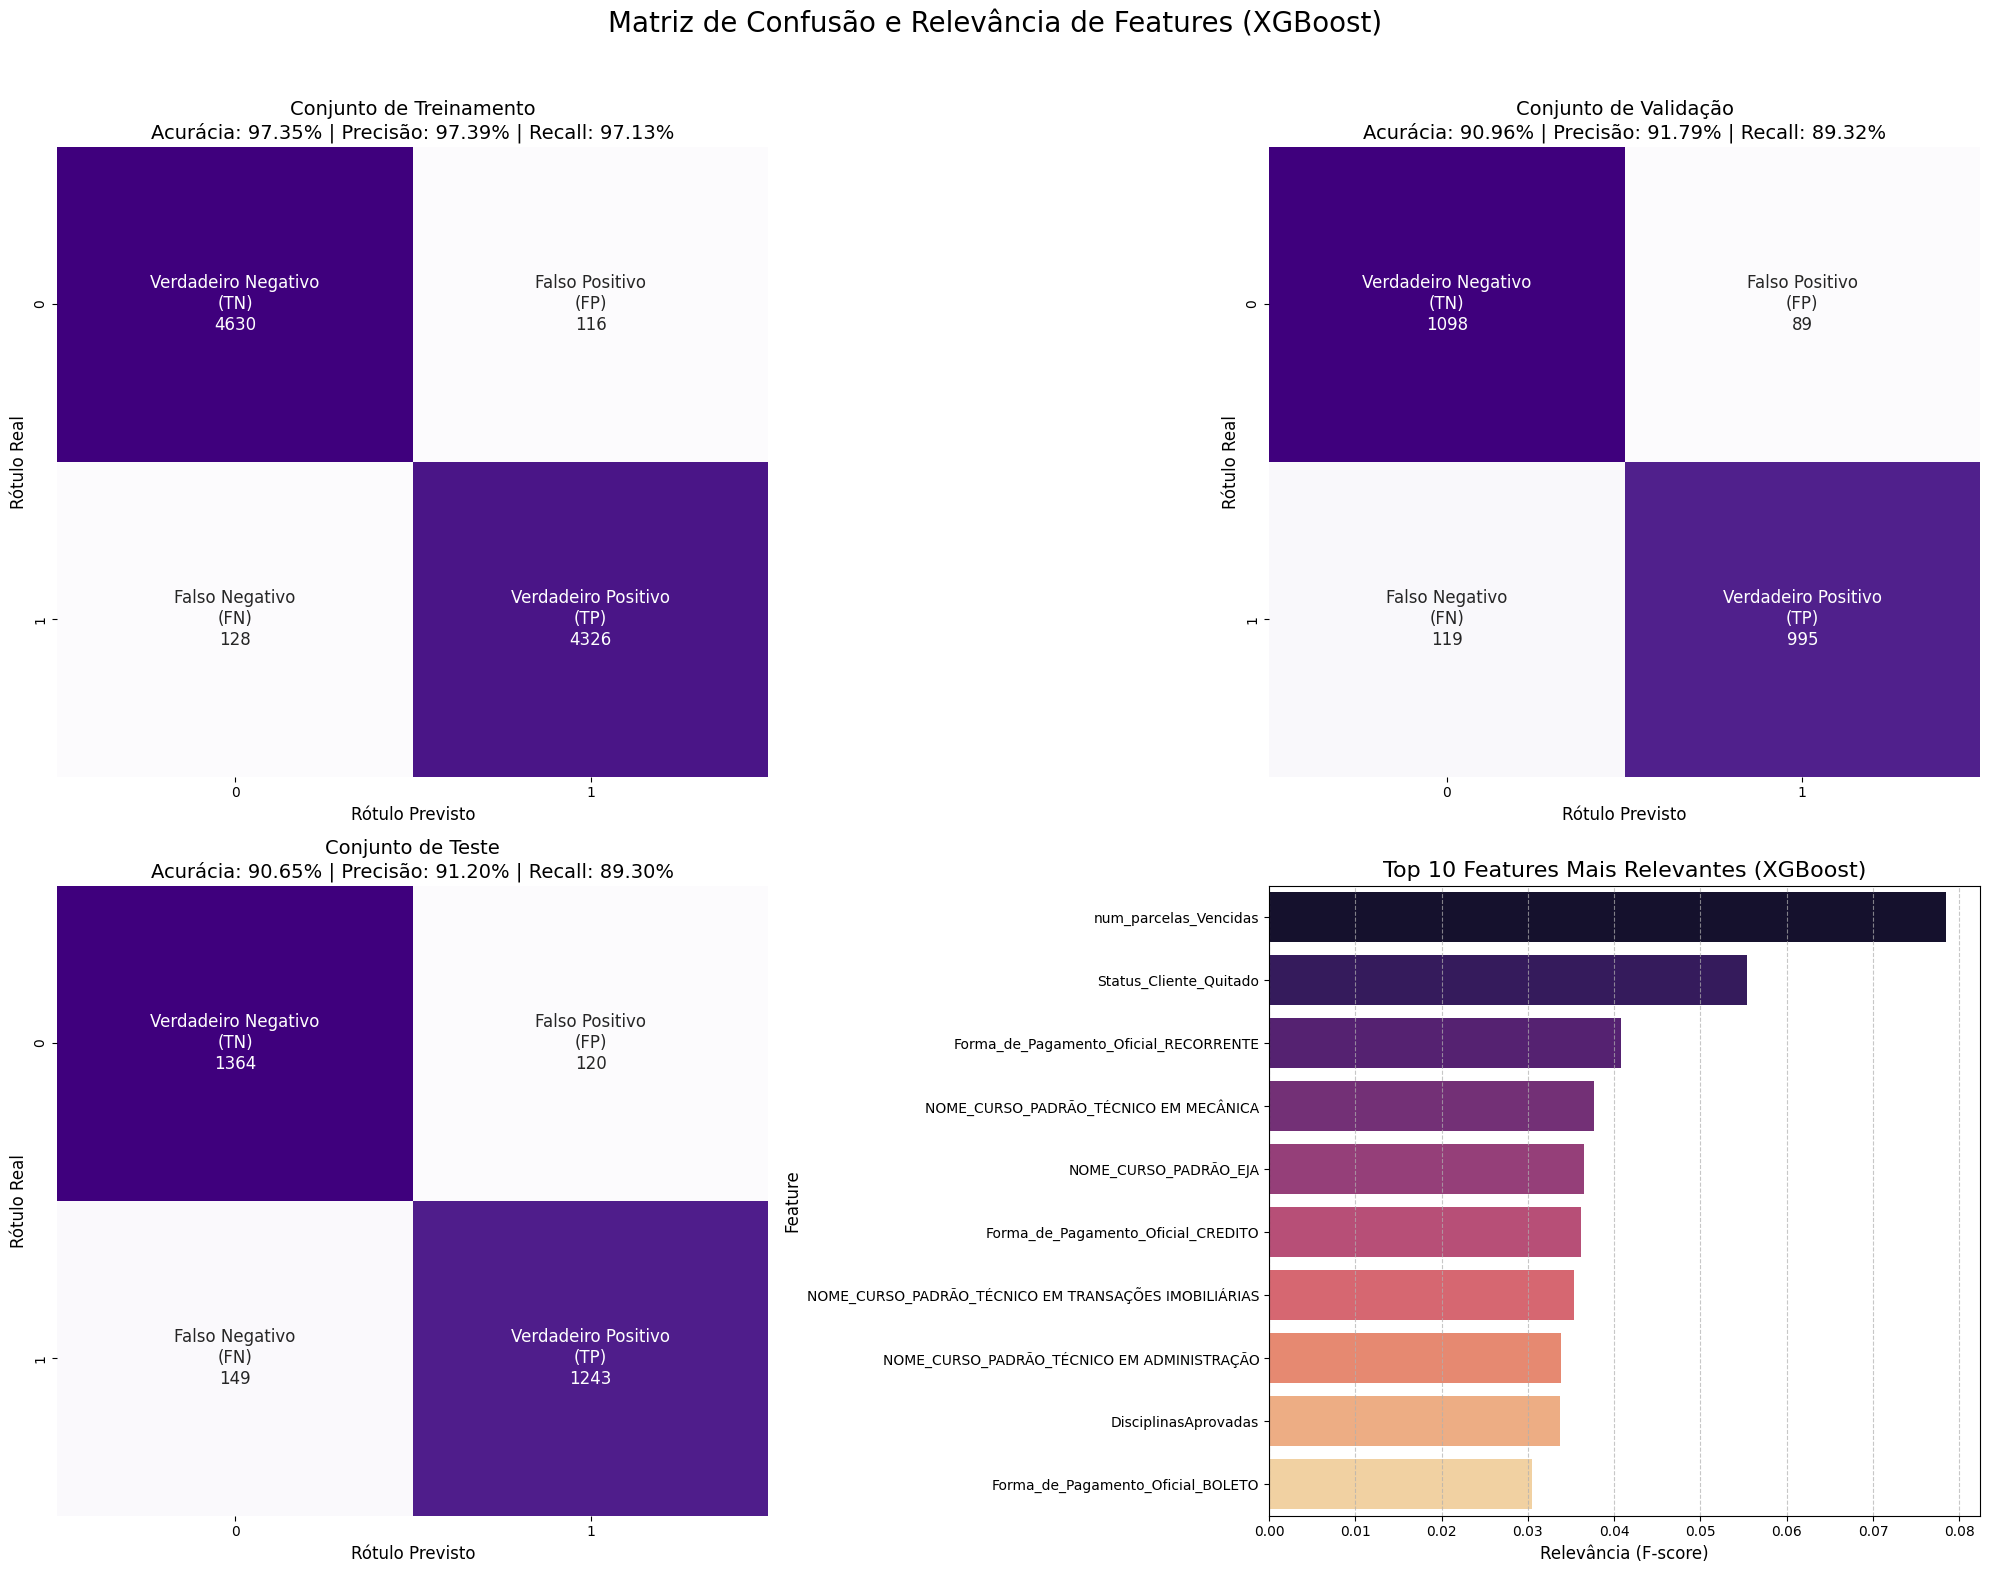

In [24]:
# --- Treinamento do Modelo (XGBoost) ---

print("Iniciando o treinamento do modelo XGBoost...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
print("Treinamento concluído.")

# --- Previsões e Probabilidades ---
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)
y_test_prob = xgb_model.predict_proba(X_test)


# --- Tabela de Probabilidades (Amostra Aleatória) ---
# Cria um DataFrame com os resultados do conjunto de teste.
xgb_predictions_df = pd.DataFrame({
    'Real': y_test.values,
    'Previsto': y_test_pred,
    'Prob_Nao_Churn (0)': y_test_prob[:, 0],
    'Prob_Churn (1)': y_test_prob[:, 1]
}, index=getattr(y_test, 'index', range(len(y_test))))

# Seleciona e exibe 10 amostras aleatórias do DataFrame de previsões.
print("\n--- 10 Amostras Aleatórias de Previsões (XGBoost) ---")
random_10_xgb_samples_df = xgb_predictions_df.sample(10, random_state=42)
print(random_10_xgb_samples_df.to_markdown(index=False))


# --- Função de Plotagem para uma Única Matriz ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.\nVerifique os rótulos y_true e y_pred.', 
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])
    sns.heatmap(cm, annot=labels, fmt='', cmap='Purples', cbar=False, ax=ax, annot_kws={"size": 12})
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---
print("\nGerando a visualização gráfica...")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Matriz de Confusão e Relevância de Features (XGBoost)', fontsize=20, y=0.98)
axes = axes.ravel()

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features (Feature Importance) ---
ax_importance = axes[3]
importances = xgb_model.feature_importances_

# Garante que temos os nomes das features
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns.tolist()
else:
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(10),
    ax=ax_importance, 
    palette='magma'
)
ax_importance.set_title('Top 10 Features Mais Relevantes (XGBoost)', fontsize=16)
ax_importance.set_xlabel('Relevância (F-score)', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Load the original data from the user-uploaded file
df_original = pd.read_csv('atendimentos_de_alunos_machine_learning.csv', delimiter=';')

# 2. Pre-process the data
# Filter for churn == 1
df_churn = df_original[df_original['churn'] == 1].copy()

# Convert boolean columns to integers
df_churn['fezPrimeiroAcesso'] = df_churn['fezPrimeiroAcesso'].astype(int)
df_churn['has_contact'] = df_churn['has_contact'].astype(int)

# Create the feature matrix X, dropping the constant 'churn' column
X = df_churn.drop('churn', axis=1)

# Ensure all data is numeric for clustering
X_numeric = X.select_dtypes(include=['number'])

# 3. Run Silhouette Analysis with increased n_init
k_range = range(2, 13) # Testing a slightly larger range
silhouette_scores = []
n_inits_robust = 20 # Using n_init=20 as requested

print(f"Iniciando Análise de Silhueta com n_init={n_inits_robust}...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=n_inits_robust, max_iter=300, random_state=42)
    kmeans.fit(X_numeric)
    score = silhouette_score(X_numeric, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"  k={k}, Silhouette Score: {score:.4f}")

# 4. Determine Optimal K
# Plot the Silhouette Scores
plt.figure(figsize=(12, 7))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.title(f'Análise de Silhueta Robusta (n_init={n_inits_robust}) para Encontrar o K Ótimo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Pontuação da Silhueta (Silhouette Score)')
plt.grid(True)
plt.savefig('robust_silhouette_analysis.png')
plt.close()

# Find the optimal k with the highest silhouette score
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]

print("\nAnálise de Silhueta completa.")
print(f"Gráfico salvo como 'robust_silhouette_analysis.png'.")
print(f"As pontuações da silhueta foram: {silhouette_scores}")
print(f"O número ótimo de clusters (k) encontrado é: {optimal_k}")

Iniciando Análise de Silhueta com n_init=20...
  k=2, Silhouette Score: 0.2189
  k=3, Silhouette Score: 0.2221
  k=4, Silhouette Score: 0.0974
  k=5, Silhouette Score: 0.1038
  k=6, Silhouette Score: 0.1754
  k=7, Silhouette Score: 0.1217
  k=8, Silhouette Score: 0.1347
  k=9, Silhouette Score: 0.1139
  k=10, Silhouette Score: 0.1373
  k=11, Silhouette Score: 0.1325
  k=12, Silhouette Score: 0.1365

Análise de Silhueta completa.
Gráfico salvo como 'robust_silhouette_analysis.png'.
As pontuações da silhueta foram: [np.float64(0.21888127525937742), np.float64(0.22214705614427815), np.float64(0.09737250750445618), np.float64(0.10379818308766701), np.float64(0.17542566041643132), np.float64(0.12172398101508501), np.float64(0.13470152631776958), np.float64(0.11385543823712915), np.float64(0.1373487121818012), np.float64(0.13246996060485042), np.float64(0.13652022067107333)]
O número ótimo de clusters (k) encontrado é: 3


In [30]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data (as in the previous step) ---
df_original = pd.read_csv('atendimentos_de_alunos_machine_learning.csv', delimiter=';')
df_churn = df_original[df_original['churn'] == 1].copy()
df_churn['fezPrimeiroAcesso'] = df_churn['fezPrimeiroAcesso'].astype(int)
df_churn['has_contact'] = df_churn['has_contact'].astype(int)
X_numeric = df_churn.drop('churn', axis=1).select_dtypes(include=['number'])

# --- 2. Perform Final Clustering with Optimal K ---
# The optimal k was found to be 3 in the robust silhouette analysis
optimal_k = 3
n_inits_robust = 20

kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', n_init=n_inits_robust, max_iter=300, random_state=42)
final_clusters = kmeans_final.fit_predict(X_numeric)

# Add the new, robustly-defined cluster labels to the dataframe
df_churn['Grupo_Robusto'] = final_clusters

# --- 3. Analyze the Final Clusters ---
final_cluster_analysis = df_churn.groupby('Grupo_Robusto').mean()
print("--- Análise dos Grupos Finais e Robustos (k=3) ---")
# Displaying key columns for a clearer interpretation
key_columns = [
    'Total__Atendimentos', 'Financeiro', 'num_parcelas_Vencidas',
    'DisciplinasAprovadas', 'percent_Docs_Pessoais', 'Bot_de_Atendimento',
    'Apoio_Pedagogico', 'Onboarding'
]
print(final_cluster_analysis[key_columns])
print("\n--- Contagem de Alunos por Grupo ---")
print(df_churn['Grupo_Robusto'].value_counts().sort_index())


# --- 4. Visualize the Final Clusters using PCA ---
pca = PCA(n_components=2)
X_pca_final = pca.fit_transform(X_numeric)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=final_clusters, cmap='viridis', alpha=0.7)
plt.title(f'Visualização dos {optimal_k} Perfis de Churn (Análise Robusta)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)

# Create legend based on the number of clusters
legend_labels = [f'Grupo {i}' for i in range(optimal_k)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.savefig('final_robust_clusters.png')
plt.close()

# --- 5. Save the final dataframe to a new CSV file ---
df_churn.to_csv('alunos_churn_grupos_robustos.csv', index=False, sep=';')

print("\nAnálise final e robusta completa.")
print(f"Clusterização realizada com k={optimal_k} e n_init={n_inits_robust}.")
print("Visualização dos clusters salva como 'final_robust_clusters.png'.")
print("Dados finais salvos em 'alunos_churn_grupos_robustos.csv'.")

--- Análise dos Grupos Finais e Robustos (k=3) ---
               Total__Atendimentos  Financeiro  num_parcelas_Vencidas  \
Grupo_Robusto                                                           
0                         1.111908    0.696527               0.133016   
1                        -0.593533   -0.346140               0.510506   
2                        -0.754085   -0.492721               0.174252   

               DisciplinasAprovadas  percent_Docs_Pessoais  \
Grupo_Robusto                                                
0                         -0.160075              -0.119157   
1                         -0.320986              -0.260120   
2                         -0.807097              -0.447338   

               Bot_de_Atendimento  Apoio_Pedagogico  Onboarding  
Grupo_Robusto                                                    
0                        0.671024          0.217753   -0.069964  
1                       -0.230812         -0.155072   -0.214351  
2       